#**GNNs Lab Notebook 3**
## Link Prediction

---

In this notebook, we will explore Graph Neural Networks and their widespread use in Link Prediction. Specifically, we will use the `Cora` dataset, and predict links between papers, which represents the existence (or absence) of a citation.

In [ ]:
import torch
from torch import Tensor
print(torch.__version__)

2.0.1+cu118


In [ ]:
# Install required packages.
import os
os.environ['TORCH'] = torch.__version__

!pip install torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install pyg-lib -f https://data.pyg.org/whl/nightly/torch-${TORCH}.html
!pip install git+https://github.com/pyg-team/pytorch_geometric.git

Looking in links: https://data.pyg.org/whl/torch-2.0.1+cu118.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 53.1 MB/s eta 0:00:00
Looking in links: https://data.pyg.org/whl/torch-2.0.1+cu118.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 27.7 MB/s eta 0:00:00
Looking in links: https://data.pyg.org/whl/nightly/torch-2.0.1+cu118.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 23.6 MB/s eta 0:00:00
  Cloning https://github.com/pyg-team/pytorch_geometric.git to /tmp/pip-req-build-f4p2dt7r
  Running command git clone --filter=blob:none --quiet https://github.com/pyg-team/pytorch_geometric.git /tmp/pip-req-build-f4p2dt7r
  Resolved https://github.com/pyg-team/pytorch_geometric.git to commit 62599d19811b0e41af9f81476ca4ef3e7e2d92e7
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for torch_geometric: filename=torch_geometric-2.4.0-py3-none-any.whl

To demonstrate, we make use of the `Cora` dataset, which is a **citation network** where nodes represent documents.
Each node is described by a 1433-dimensional bag-of-words feature vector.
Two documents are connected if there exists a citation link between them.

This dataset was first introduced by [Yang et al. (2016)](https://arxiv.org/abs/1603.08861) as one of the datasets of the `Planetoid` benchmark suite.
We again can make use [PyTorch Geometric](https://github.com/rusty1s/pytorch_geometric) for an easy access to this dataset via [`torch_geometric.datasets.Planetoid`](https://pytorch-geometric.readthedocs.io/en/latest/modules/datasets.html#torch_geometric.datasets.Planetoid):

In [ ]:
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures

dataset = Planetoid(root='data/Planetoid', name='Cora', transform=NormalizeFeatures())

print()
print(f'Dataset: {dataset}:')
print('======================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

data = dataset[0]  # Get the first graph object (the only one in this case)

Processing...



Dataset: Cora():
Number of graphs: 1
Number of features: 1433
Number of classes: 7


Done!


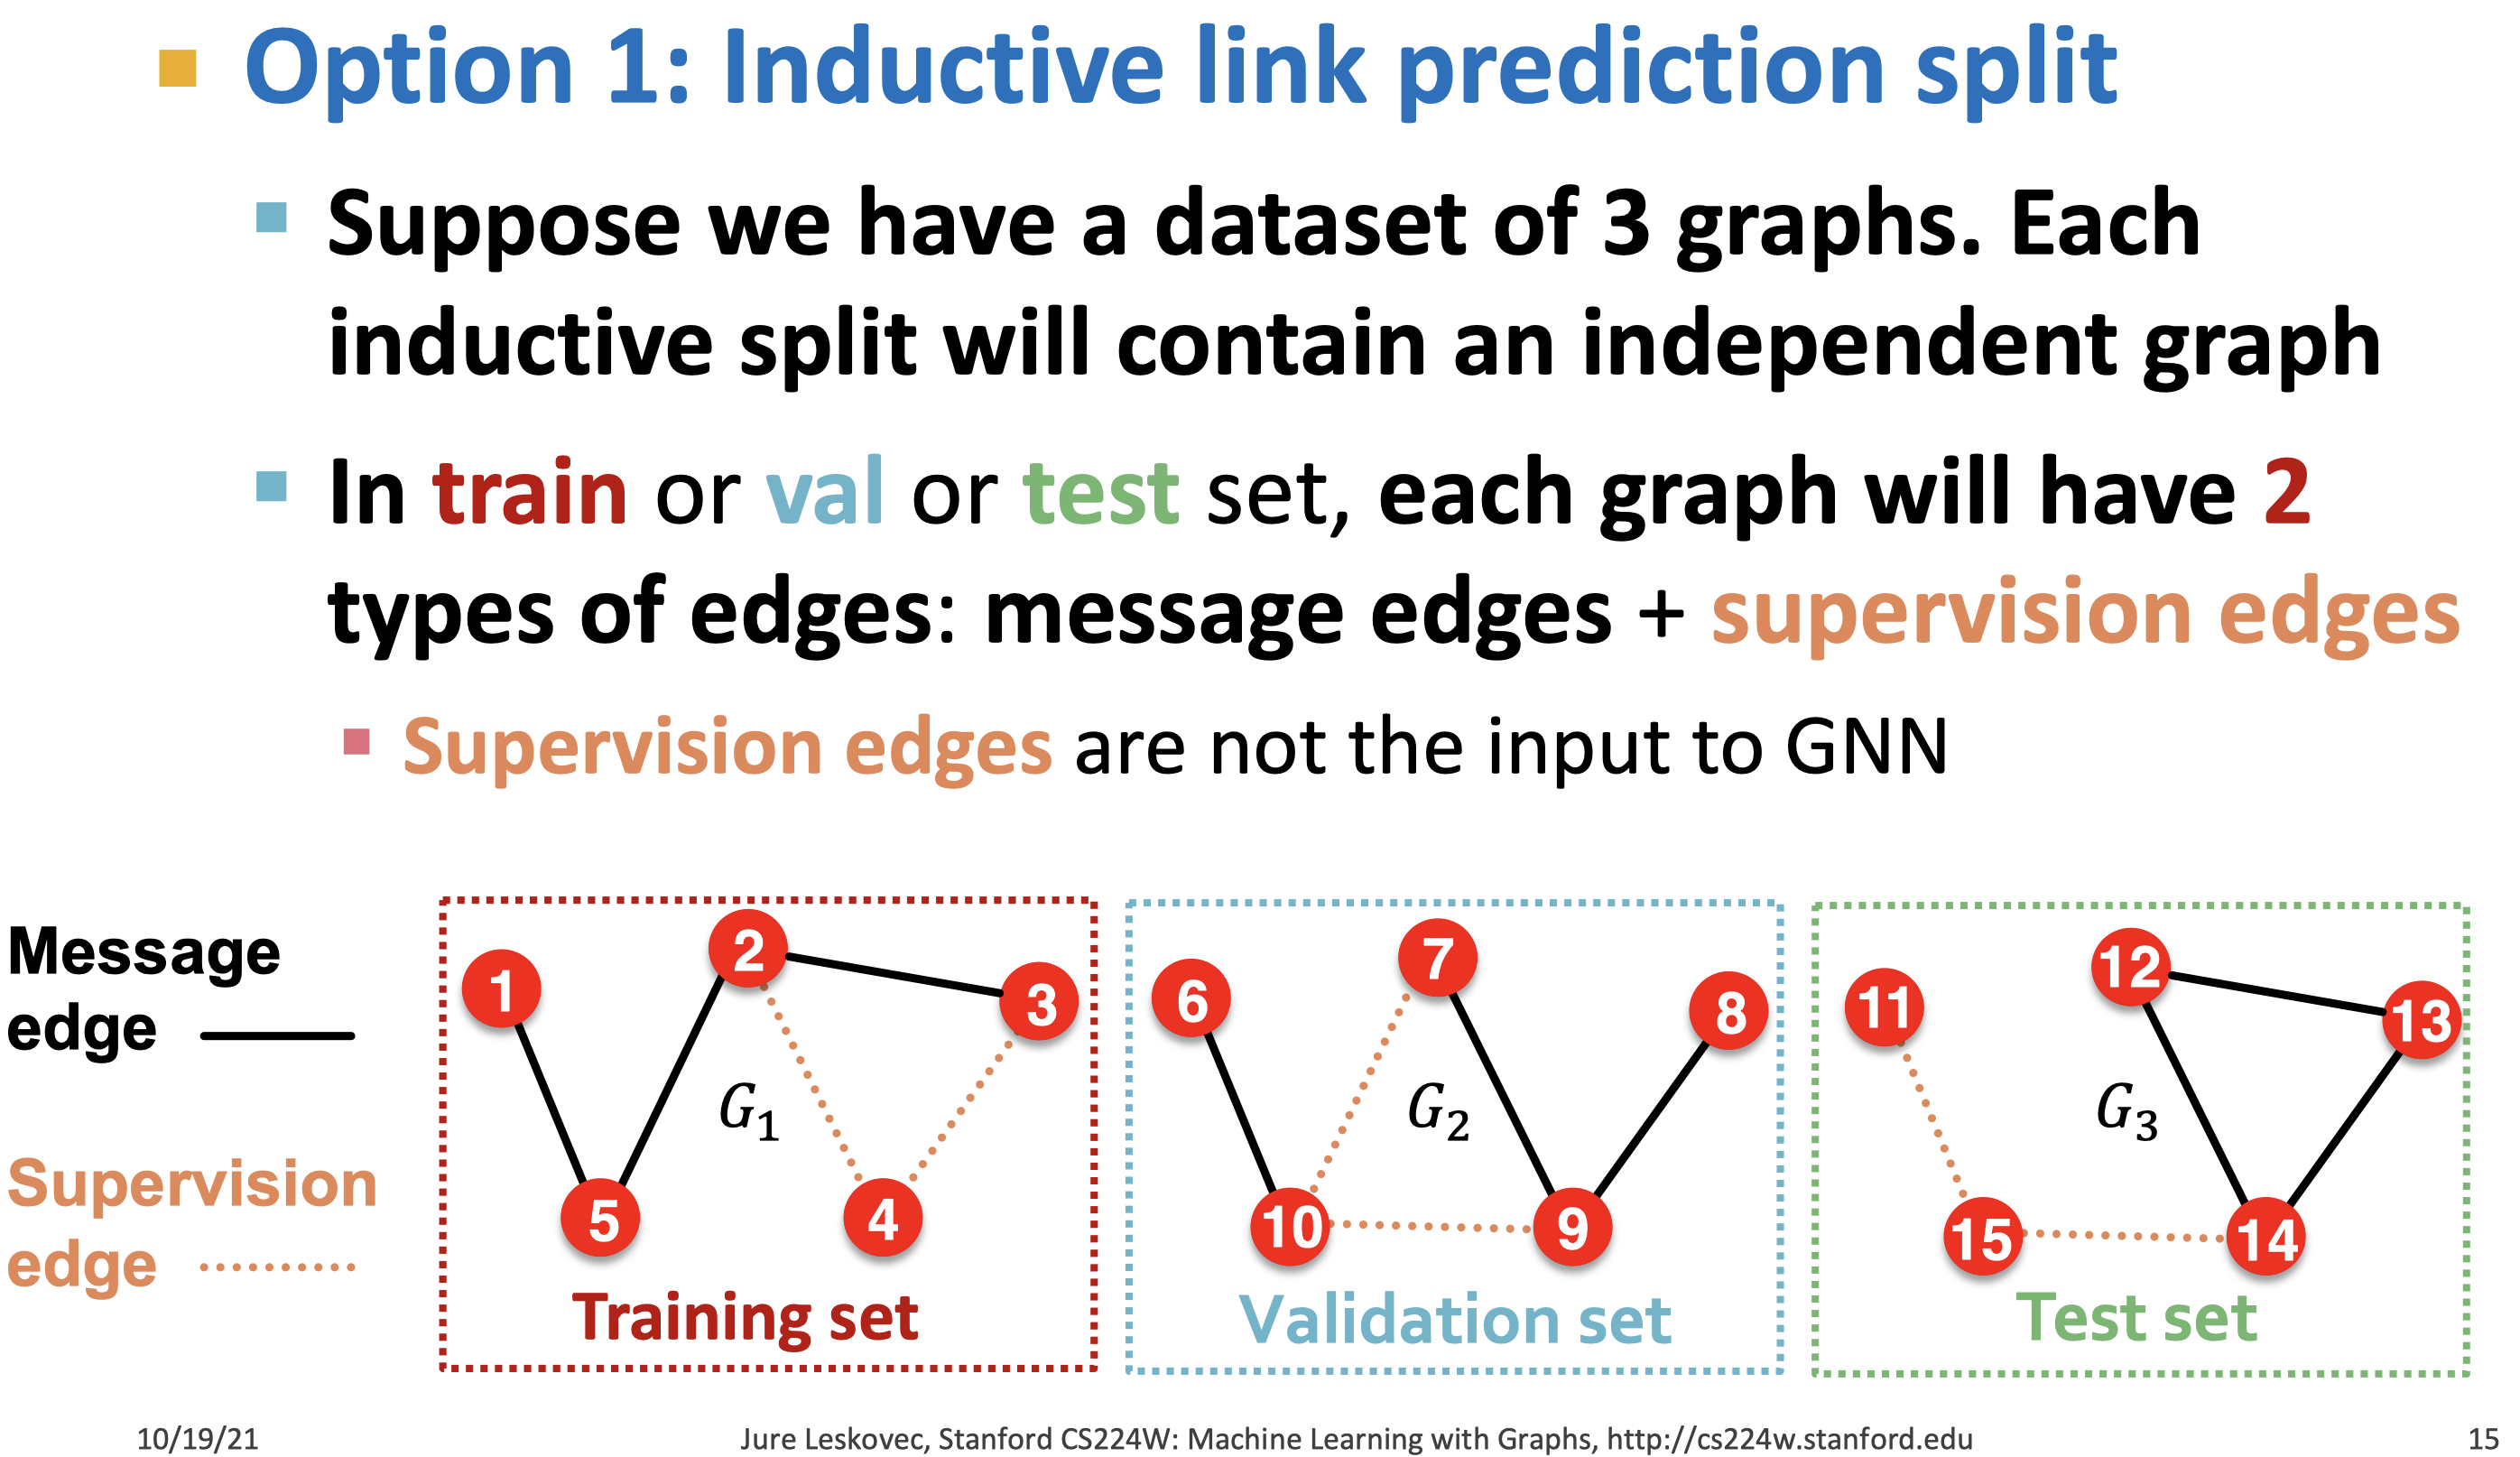

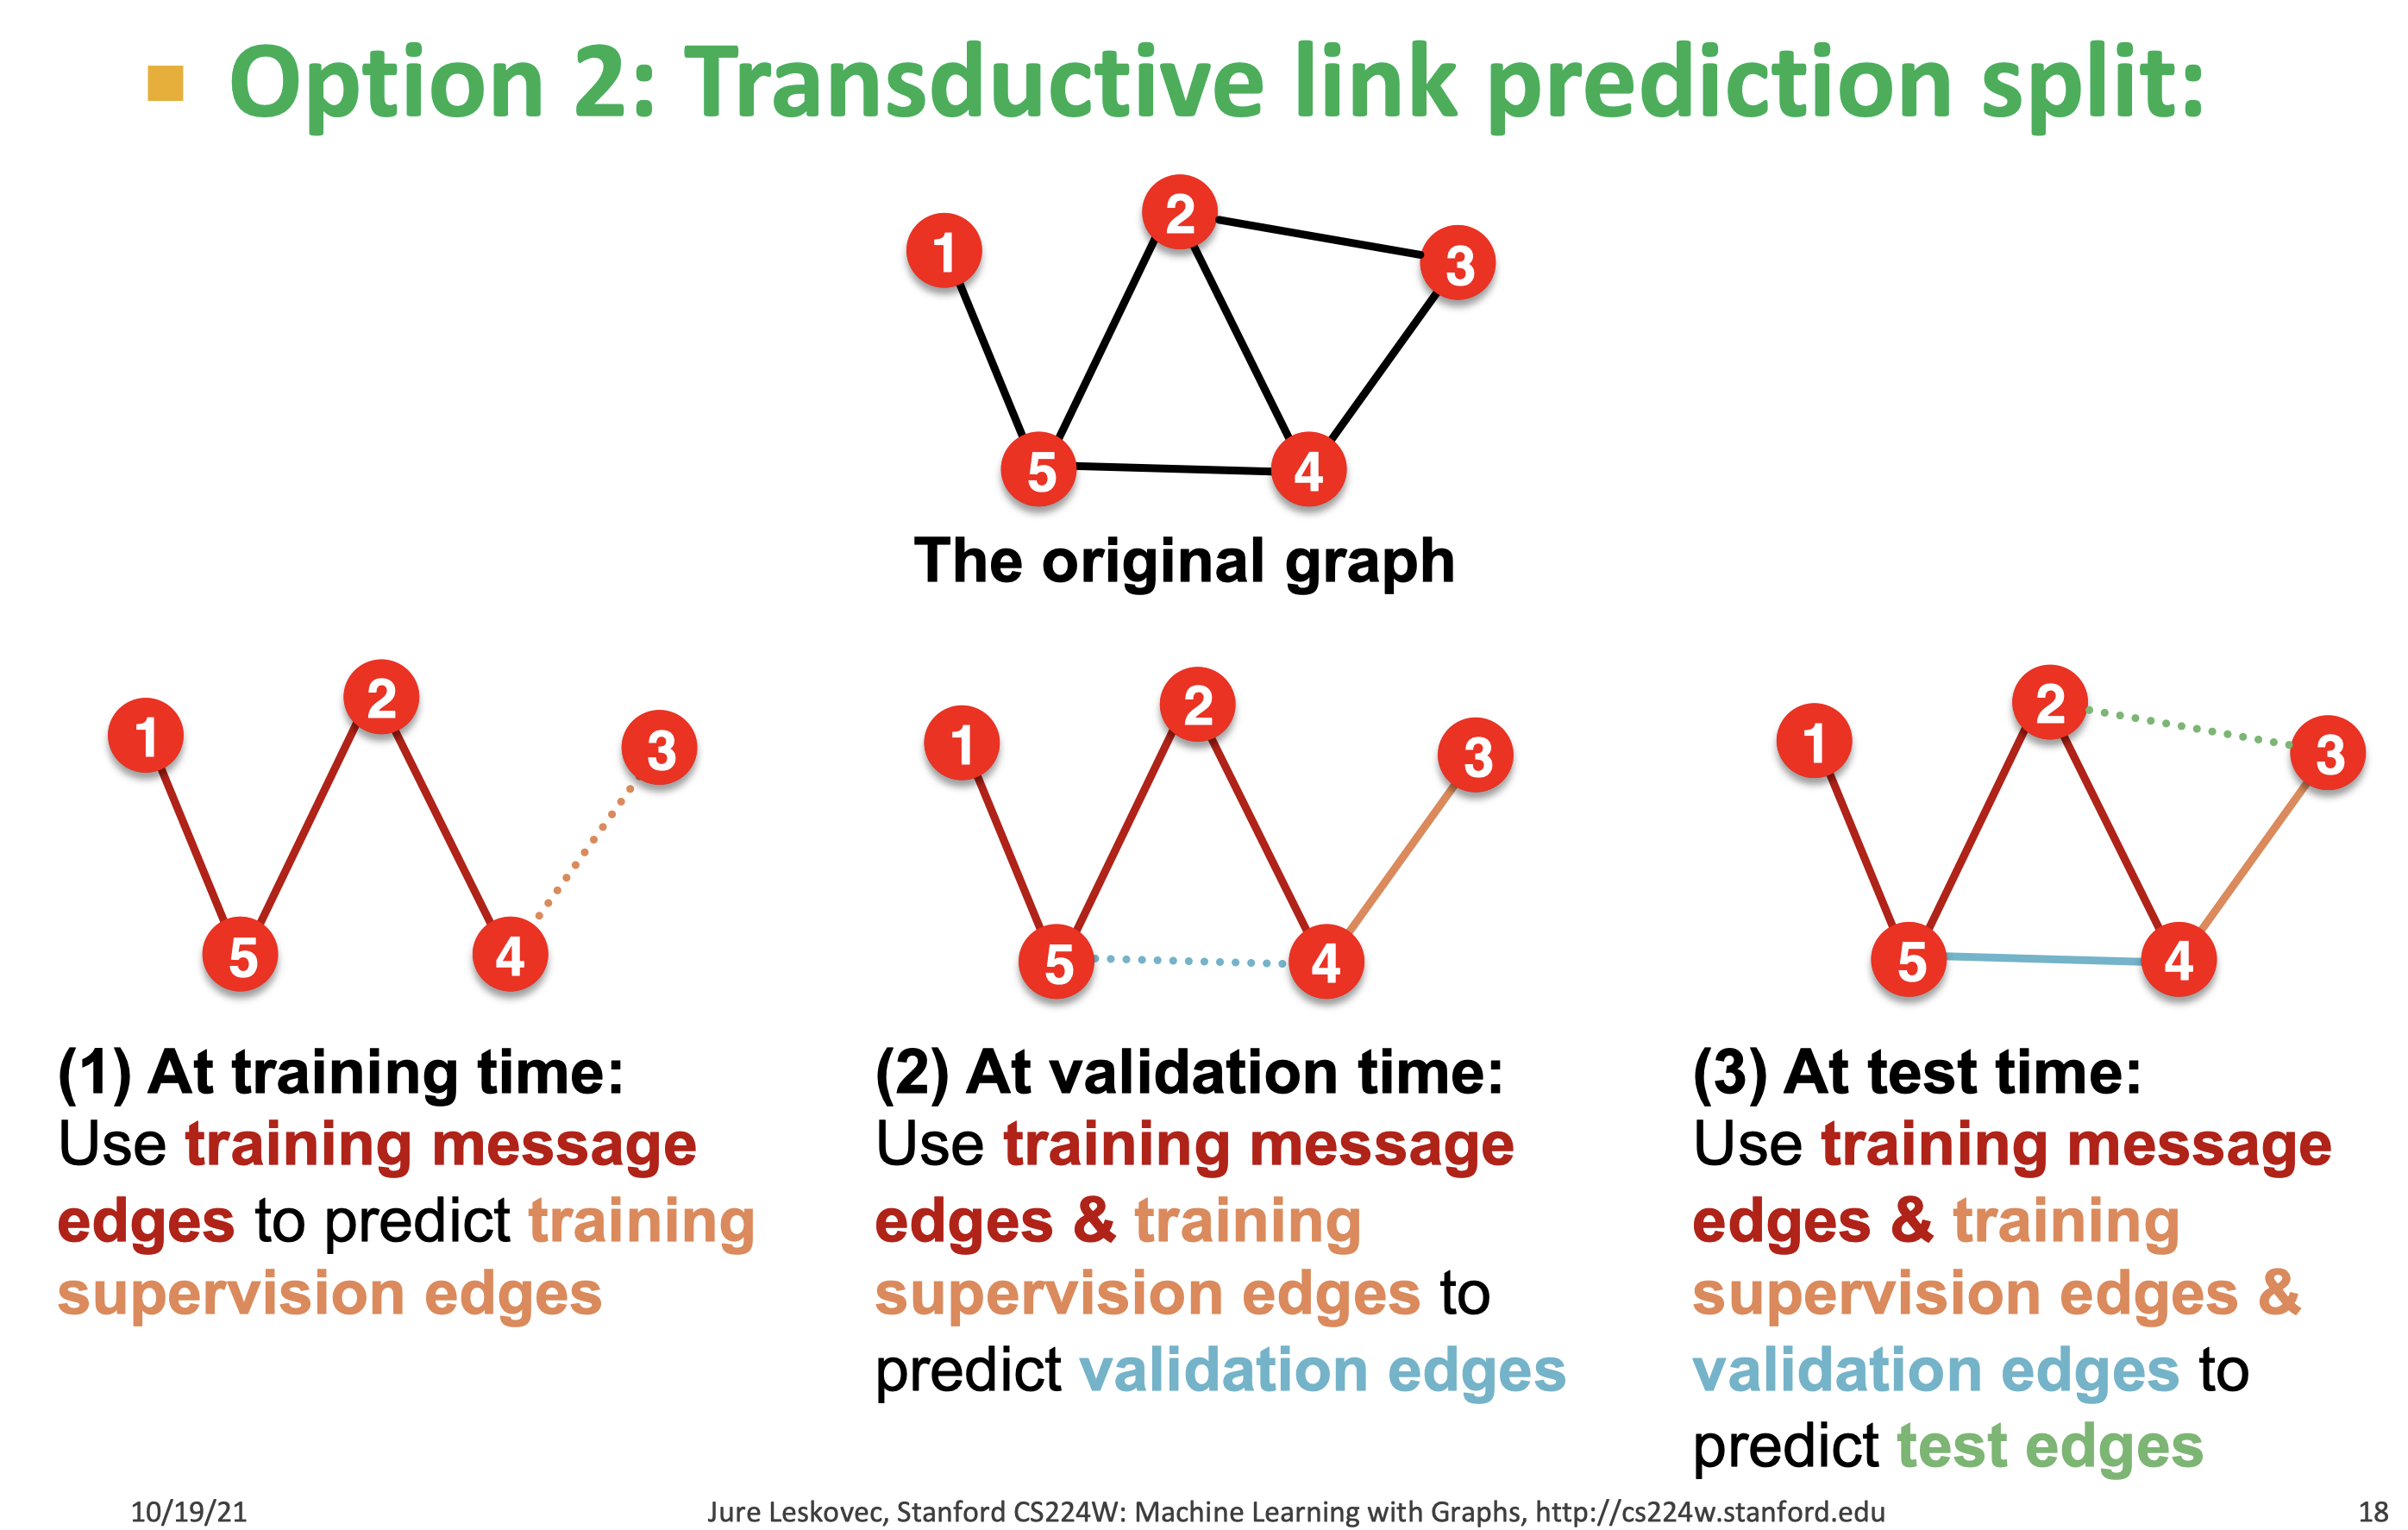

## Defining Edge-level Training Splits

Since our data is now ready-to-be-used, we can split the ratings of users into training, validation, and test splits.
This is needed in order to ensure that we leak no information about edges used during evaluation into the training phase.

Specifically, we need to differentiate the edges that will be used by the GNNs (Message-Passing edges), and the edges that will be used for the computation of the final Loss (supervision edges). In the figure above, this is the case of "Transductive Link Prediction Split".

For this, we make use of the [`transforms.RandomLinkSplit`](https://pytorch-geometric.readthedocs.io/en/latest/modules/transforms.html#torch_geometric.transforms.RandomLinkSplit) transformation from PyG.
This transforms randomly divides the edges into training, validation and test edges.
The `disjoint_train_ratio` parameter further separates edges in the training split into edges used for message passing (`edge_index`) and edges used for supervision (`edge_label_index`).

In [ ]:
import torch_geometric.transforms as T

# For this, we first split the set of edges into
# training (70%) and testing edges (30%).
# Across the training edges, we use 70% of edges for message passing,
# and 30% of edges for supervision.
# We further want to generate fixed negative edges for evaluation with a ratio of 1:1.
# Overall, we can leverage the `RandomLinkSplit()` transform for this from PyG:
transform = T.RandomLinkSplit(
    num_val=0.0,
    num_test=0.3,
    disjoint_train_ratio=0.3,
    add_negative_train_samples=True,
    neg_sampling_ratio=1.0
)

train_data, val_data, test_data = transform(data)
print("Training data:")
print("==============")
print(train_data)
print()
print("Test data:")
print("================")
print(test_data)

Training data:
Data(x=[2708, 1433], edge_index=[2, 5173], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708], edge_label=[4434], edge_label_index=[2, 4434])

Test data:
Data(x=[2708, 1433], edge_index=[2, 7390], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708], edge_label=[6332], edge_label_index=[2, 6332])


## Creating a Link-level GNN

We are now ready to create our GNN.
The GNN is responsible for learning enriched node representations from the graph, which can be then used to derive edge-level predictions.
For defining our GNN, we make use of [`nn.GCNConv`](https://pytorch-geometric.readthedocs.io/en/latest/generated/torch_geometric.nn.conv.GCNConv.html#torch_geometric.nn.conv.GCNConv), along with a classifier for edge-level features.

To recap, the **GCN layer** ([Kipf et al. (2017)](https://arxiv.org/abs/1609.02907)) is defined as

$$
\mathbf{x}_v^{(\ell + 1)} = \mathbf{W}^{(\ell + 1)} \sum_{w \in \mathcal{N}(v) \, \cup \, \{ v \}} \frac{1}{c_{w,v}} \cdot \mathbf{x}_w^{(\ell)}
$$

where $\mathbf{W}^{(\ell + 1)}$ denotes a trainable weight matrix of shape `[num_output_features, num_input_features]` and $c_{w,v}$ refers to a fixed normalization coefficient for each edge.

We provide two implementations for this edge-level classifier. The first one uses a single-layer neural network, which takes as input the concatenated embeddings of the two nodes (as computed by the GNN). This layer's output is a single neuron, responsible for the binary classification (positive or negative edge). The second classifier is a much simpler one, that applies the dot-product between the source and destination node, to compute the final logits.

In [ ]:
from pandas.core.arrays.timedeltas import periods_per_second
from torch_geometric.nn import GCNConv, SAGEConv, to_hetero
from torch.nn import Linear, ReLU, Sigmoid

class GNN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels):
        super().__init__()

        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)

    def forward(self, x: Tensor, edge_index: Tensor) -> Tensor:
        out = self.conv1(x, edge_index)
        out = ReLU()(self.conv2(out, edge_index))
        return out

# We build two classifiers. The first one applies the dot-product between source and destination
# node embeddings to derive edge-level predictions:
class Classifier(torch.nn.Module):
    def forward(self, x: Tensor, edge_label_index: Tensor) -> Tensor:
        # Convert node embeddings to edge-level representations:
        node_feat_source = x[edge_label_index[0]]
        node_feat_dest = x[edge_label_index[1]]

        # Apply dot-product to get a prediction per supervision edge:
        return (node_feat_source * node_feat_dest).sum(dim=-1)

# The second one concatenates source and destination
# node embeddings and applies a final linear layer to make the edge-level prediction:
class ClassifierMLP(torch.nn.Module):
  def __init__(self, in_channels):
    super().__init__()
    self.lin = Linear(2 * in_channels, 1)

  def forward(self, x: Tensor, edge_label_index: Tensor):
    node_feat_source = x[edge_label_index[0]]
    node_feat_dest = x[edge_label_index[1]]
    edge_features = torch.cat([x[edge_label_index[0]], x[edge_label_index[1]]], dim=-1)

    out = self.lin(edge_features)
    return out

class Model(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels):
        super().__init__()
        # Instantiate homogeneous GNN:
        self.gnn = GNN(in_channels, hidden_channels)

        self.classifier = Classifier()
        self.classifierMLP = ClassifierMLP(hidden_channels)

    def forward(self, x: Tensor, edge_index: Tensor, edge_label_index: Tensor) -> Tensor:
        pred = self.gnn(x, edge_index)

        # Uncomment the final classifier that you want to use

        #pred = self.classifierMLP(pred, edge_label_index).squeeze()
        pred = self.classifier(pred, edge_label_index)

        return pred

model = Model(in_channels=data.x.shape[-1], hidden_channels=64)

print(model)

Model(
  (gnn): GNN(
    (conv1): GCNConv(1433, 64)
    (conv2): GCNConv(64, 64)
  )
  (classifier): Classifier()
  (classifierMLP): ClassifierMLP(
    (lin): Linear(in_features=128, out_features=1, bias=True)
  )
)


## Training the GNN Model

For the training of the model, we use the `train_data` that we constructed with `RandomLinkSplit`.

It is important to note, that we must use the `edge_index` for the GNNs during the Message-Passing, and `edge_label_index` to compute the predictions for the Loss Function (supervision). This ensures that there will be no data leakage, and the GNNs won't "*propagate*" through the edges that they will have to make predictions for.

In [ ]:
import tqdm
import torch.nn.functional as F

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: '{device}'")

model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

model.train()

for epoch in range(1, 50):
    optimizer.zero_grad()

    train_data.to(device)
    pred = model(train_data.x, train_data.edge_index, train_data.edge_label_index)
    loss = F.binary_cross_entropy_with_logits(pred, train_data.edge_label)

    loss.backward()
    optimizer.step()
    print(f"Epoch: {epoch:03d}, Loss: {float(loss):.4f}")

Device: 'cpu'
Epoch: 001, Loss: 0.6930
Epoch: 002, Loss: 0.6929
Epoch: 003, Loss: 0.6927
Epoch: 004, Loss: 0.6924
Epoch: 005, Loss: 0.6920
Epoch: 006, Loss: 0.6915
Epoch: 007, Loss: 0.6908
Epoch: 008, Loss: 0.6900
Epoch: 009, Loss: 0.6890
Epoch: 010, Loss: 0.6879
Epoch: 011, Loss: 0.6867
Epoch: 012, Loss: 0.6853
Epoch: 013, Loss: 0.6840
Epoch: 014, Loss: 0.6828
Epoch: 015, Loss: 0.6818
Epoch: 016, Loss: 0.6811
Epoch: 017, Loss: 0.6806
Epoch: 018, Loss: 0.6804
Epoch: 019, Loss: 0.6801
Epoch: 020, Loss: 0.6796
Epoch: 021, Loss: 0.6789
Epoch: 022, Loss: 0.6779
Epoch: 023, Loss: 0.6769
Epoch: 024, Loss: 0.6759
Epoch: 025, Loss: 0.6751
Epoch: 026, Loss: 0.6743
Epoch: 027, Loss: 0.6737
Epoch: 028, Loss: 0.6730
Epoch: 029, Loss: 0.6722
Epoch: 030, Loss: 0.6713
Epoch: 031, Loss: 0.6704
Epoch: 032, Loss: 0.6694
Epoch: 033, Loss: 0.6683
Epoch: 034, Loss: 0.6672
Epoch: 035, Loss: 0.6661
Epoch: 036, Loss: 0.6651
Epoch: 037, Loss: 0.6640
Epoch: 038, Loss: 0.6629
Epoch: 039, Loss: 0.6617
Epoch: 040,

## Evaluation on Test Set

For the evaluation of our model, we use the `ROC_AUC` score, which takes as input the predicted logits, and measures how well our model can distinguish between a positive and a negative sample.

Also, the same distinction applies between `edge_index` and `edge_label_index` in the Test Set case, in order to properly evaluate our model on unseen edges.

In [ ]:
from sklearn.metrics import roc_auc_score

preds = []
ground_truths = []
with torch.no_grad():
  model.eval()
  pred = model(test_data.x, test_data.edge_index, test_data.edge_label_index)
  ground_truth = test_data.edge_label

pred = pred.cpu().numpy()
ground_truth = ground_truth.cpu().numpy()
auc = roc_auc_score(ground_truth, pred)
print()
print(f"Validation AUC: {auc:.4f}")


Validation AUC: 0.7040


# Further Reading

## Defining Mini-batch Loaders

While this step is not strictly necessary for small-scale graphs, it is absolutely necessary to apply mini-batch loaders on larger graphs that do not fit onto GPU memory otherwise.

One of the most commonly used techniques, is to sample neighborhoods around the node/edge that we make our prediction on. One such module is the [`loader.LinkNeighborLoader`](https://pytorch-geometric.readthedocs.io/en/latest/modules/loader.html#torch_geometric.loader.LinkNeighborLoader) which samples multiple hops from both ends of a link and creates a subgraph from it. From these subgraphs, the loader creates mini-batches that can fit into less GPU memory.

## Heterogeneous GNN

The task of *Knowledge Graph Reasoning* is also a quite common application of Link Prediction, but on heterogeneous data. The `Cora` dataset that we worked with in this notebook, is a homogeneous graph, that doesn't define discrete node/edge Types on the graph.

In the case of Heterogeneous Graphs, our GNN Modules must also take into account the Edge Type during the Message-Passing. Pytorch Geometric, provides us with three ways to create GNN models for heterogeneous graphs:
1. Automatically convert a homogeneous GNN model to a heterogeneous GNN model by making use of [`torch_geometric.nn.to_hetero()`](https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html?highlight=to_hetero#torch_geometric.nn.to_hetero_transformer.to_hetero) or `torch_geometric.nn.to_hetero_with_bases()`

2. Define individual functions for different types using PyG's wrapper [`conv.HeteroConv`](https://pytorch-geometric.readthedocs.io/en/latest/generated/torch_geometric.nn.conv.HeteroConv.html#torch_geometric.nn.conv.HeteroConv) for heterogeneous convolution

3. Deploy existing (or write your own) heterogeneous GNN operators

## Extra Tools


There are several other popular tools for Machine Learning on Graphs:

- [Deep Graph Library](https://www.dgl.ai/) (DGL) is a Python package built for easy implementation of graph neural network model family, on top of existing DL frameworks (currently supporting PyTorch, MXNet and TensorFlow). It offers a versatile control of message passing, speed optimization via auto-batching and highly tuned sparse matrix kernels, and multi-GPU/CPU training to scale to graphs of hundreds of millions of nodes and edges.

- [Spektral](https://graphneural.network/) is a Python library for graph deep learning, based on the Keras API and TensorFlow 2. The main goal of this project is to provide a simple but flexible framework for creating graph neural networks (GNNs).

- [GraphGym](https://pytorch-geometric.readthedocs.io/en/latest/advanced/graphgym.html) is a platform for exploring different GNN designs and tasks, integrated as part of PyTorch Geometric. It features modularized GNN implementation, standardized GNN evaluation, and reproducible and scalable experiment management.